In [1]:
import numpy
import pandas
from matplotlib import pyplot
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [2]:
d = './joint_eternal.xlsx'
data = pandas.read_excel(d)
data

,Unnamed: 0,ex,Anderson-Darling test__train,Shapiro-Wilk test__train,Skewness statistic__train,Kurtosis__train,Levene's test__train,Brown–Forsythe test test__train,Augmented Dickey-Fuller test__train,OLS regression on Y significance statistic__train,...,SMAPE measure__test,sample__test,dimredu,pre,lag,model,model kwg,fs,param,dataset
0,0,1,1.000000,1.000000,0.340153,0.847806,0.149346,0.149379,0.000000e+00,0.772145,...,0.058470,test,No,No,5,NN,Linear;L=20_2_1;DROP=0.0_0.0_0.0;X_LeRELU_LeRE...,No,dimredu=No | pre=No | lag=5 | model=NN | fs=No,TS1
1,1,2,1.000000,1.000000,0.355006,0.874002,0.400799,0.401596,4.120000e-29,0.385945,...,0.057994,test,No,No,5,NN,Linear;L=20_2_1;DROP=0.0_0.0_0.0;X_LeRELU_LeRE...,No,dimredu=No | pre=No | lag=5 | model=NN | fs=No,TS1
2,2,3,0.999988,0.999997,0.277252,0.817335,0.311787,0.330074,0.000000e+00,0.790446,...,0.053987,test,No,No,5,NN,Linear;L=256_128_64_1;DROP=0.5_05_0.5_0.0;X_Le...,No,dimredu=No | pre=No | lag=5 | model=NN | fs=No,TS1
3,3,4,1.000000,0.999999,0.232122,0.848495,0.329393,0.325739,4.660000e-27,0.876221,...,0.052307,test,No,No,5,NN,Linear;L=256_128_64_1;DROP=0.5_05_0.5_0.0;X_Le...,No,dimredu=No | pre=No | lag=5 | model=NN | fs=No,TS1
4,4,5,1.000000,1.000000,0.269471,0.882250,0.395016,0.396011,0.000000e+00,0.998913,...,0.051364,test,No,No,5,NN,Linear;L=20_2_1;DROP=0.0_0.0_0.0;X_LeRELU_LeRE...,No,dimredu=No | pre=No | lag=5 | model=NN | fs=No,TS1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,490,67,1.000000,1.000000,0.323771,1.000000,0.043964,0.052275,0.000000e+00,1.000000,...,0.244943,test,No,STDSCAL,5,NN,GRU;L=256_128_64_1;DROP=0.5_05_0.5_0.0;X_LeREL...,No,dimredu=No | pre=STDSCAL | lag=5 | model=NN | ...,TS8
491,491,68,1.000000,1.000000,0.094713,1.000000,0.585289,0.595604,0.000000e+00,1.000000,...,0.212216,test,No,STDSCAL,40,NN,Linear;L=20_2_1;DROP=0.0_0.0_0.0;X_LeRELU_LeRE...,No,dimredu=No | pre=STDSCAL | lag=40 | model=NN |...,TS8
492,492,69,1.000000,1.000000,0.311241,1.000000,0.738609,0.730884,0.000000e+00,1.000000,...,0.209857,test,No,STDSCAL,40,NN,Linear;L=256_128_64_1;DROP=0.5_05_0.5_0.0;X_Le...,No,dimredu=No | pre=STDSCAL | lag=40 | model=NN |...,TS8
493,493,70,1.000000,1.000000,0.849849,1.000000,0.511690,0.497770,0.000000e+00,1.000000,...,0.220299,test,No,STDSCAL,40,NN,GRU;L=20_2_1;DROP=0.0_0.0_0.0;X_LeRELU_LeRELU;...,No,dimredu=No | pre=STDSCAL | lag=40 | model=NN |...,TS8


In [3]:
data.columns

Index(['Unnamed: 0', 'ex', 'Anderson-Darling test__train',
       'Shapiro-Wilk test__train', 'Skewness statistic__train',
       'Kurtosis__train', 'Levene's test__train',
       'Brown–Forsythe test test__train',
       'Augmented Dickey-Fuller test__train',
       'OLS regression on Y significance statistic__train',
       'OLS regression on Y R-squared statistic__train',
       'Self-Model regression on Y R-squared statistic__train',
       'Ljung-Box autocorrelation test__train',
       'Kolmogorov-Smirnov statistic__train',
       'Kullback-Leibler statistic__train', 'R-squared measure__train',
       'R-squared adjusted measure__train', 'SMAPE measure__train',
       'sample__train', 'Anderson-Darling test__test',
       'Shapiro-Wilk test__test', 'Skewness statistic__test', 'Kurtosis__test',
       'Levene's test__test', 'Brown–Forsythe test test__test',
       'Augmented Dickey-Fuller test__test',
       'OLS regression on Y significance statistic__test',
       'OLS regressio

In [4]:
def get_size(x):
    if '20_2_1' in x:
        return 0 # 'small'
    elif '64_64_64_1' in x:
        return 1 # 'med'
    elif '256_128_64_1' in x:
        return 2 # 'big'
    else:
        raise Exception('invalid lag appeared: {0}'.format(x))


def get_drops(x):
    if 'DROP=0.0_' in x:
        return 0 # 'zero'
    elif 'DROP=0.5' in x:
        return 0.5 # 'big'
    elif ('DROP=0.1' in x) or ('DROP=0.2' in x):
        return 0.1 # 'small'
    else:
        raise Exception('invalid drop rate appeared: {0}'.format(x))


def get_act(x):
    if 'LeRELU' in x:
        return 0 # 'leakyrelu'
    elif 'MISH' in x:
        return 1 # 'mish'
    else:
        raise Exception('invalid activation appeared: {0}'.format(x))


def get_wd(x):
    if 'wd=0.01' in x:
        return 0.01 # 'med'
    elif 'wd=0.001' in x:
        return 0.001 # 'small'
    else:
        return 0 # 'zero'


def get_lr(x):
    if ('ADAMAX=0.1' in x) or ('AdamW=0.1' in x):
        return 0.1 # 'big'
    elif ('ADAMAX=0.05' in x) or ('AdamW=0.05' in x):
        return 0.05 # 'mid'
    elif ('ADAMAX=0.01' in x) or ('AdamW=0.01' in x):
        return 0.01 # 'small'
    elif ('ADAMAX=0.001' in x) or ('AdamW=0.001' in x):
        return 0.001 # 'tiny'
    else:
        raise Exception('invalid lr appeared: {0}'.format(x))


def get_loss(x):
    if 'MSELoss' in x:
        return 0 # 'mse'
    elif 'L1Loss' in x:
        return 1 # 'mae'
    else:
        raise Exception('invalid loss appeared: {0}'.format(x))


def get_dimredu(x):
    if x == 'No':
        return 0
    elif x == 'PCA_mle':
        return 1
    else:
        raise Exception('invalid dimredu appeared: {0}'.format(x))


def get_pre(x):
    if x == 'No':
        return 0
    elif x == 'STDSCAL':
        return 1
    else:
        raise Exception('invalid pre appeared: {0}'.format(x))


def get_fs(x):
    if x == 'No':
        return 0
    elif x == 'KENDSIG_05':
        return 1
    else:
        raise Exception('invalid fs appeared: {0}'.format(x))


data['model_size'] = data['model kwg'].apply(func=get_size)
data['model_dr'] = data['model kwg'].apply(func=get_drops)
data['model_act'] = data['model kwg'].apply(func=get_act)
data['model_wd'] = data['model kwg'].apply(func=get_wd)
data['model_lr'] = data['model kwg'].apply(func=get_lr)
data['model_loss'] = data['model kwg'].apply(func=get_loss)
data['model_dimredu'] = data['dimredu'].apply(func=get_dimredu)
data['model_pre'] = data['pre'].apply(func=get_pre)
data['model_fs'] = data['fs'].apply(func=get_fs)
data['stat_ad'] = data['Anderson-Darling test__train'].copy()
data['stat_df'] = data['Augmented Dickey-Fuller test__train'].copy() 
data['stat_ks'] = data['Kolmogorov-Smirnov statistic__train'].copy() 
data['stat_kl'] = data['Kullback-Leibler statistic__train'].copy() 
data['target_r2'] = data['R-squared measure__test'].copy()
data['target_sm'] = data['SMAPE measure__test'].copy()
data['target_r2_o'] = data['R-squared measure__test'] / data['R-squared measure__train']
data['target_sm_o'] = data['SMAPE measure__test'] / data['SMAPE measure__train']

data[['model_size', 'model_dr', 'model_act', 'model_wd', 'model_lr', 'dimredu', 'pre', 'fs', 'stat_ad', 'stat_df', 'stat_ks', 'stat_kl', 
      'target_r2', 'target_sm', 'target_r2_o', 'target_sm_o']]

,model_size,model_dr,model_act,model_wd,model_lr,dimredu,pre,fs,stat_ad,stat_df,stat_ks,stat_kl,target_r2,target_sm,target_r2_o,target_sm_o
0,0,0.0,0,0.000,0.05,No,No,No,1.000000,0.000000e+00,0.000001,0.995323,1.000000,0.058470,22.672090,1.084305
1,0,0.0,0,0.000,0.01,No,No,No,1.000000,4.120000e-29,0.000083,0.995358,1.000000,0.057994,22.165254,1.068278
2,2,0.5,0,0.000,0.05,No,No,No,0.999988,0.000000e+00,0.000001,0.994327,0.093701,0.053987,2.157640,0.998632
3,2,0.5,0,0.000,0.01,No,No,No,1.000000,4.660000e-27,0.000001,0.996067,0.066373,0.052307,1.429022,0.940946
4,0,0.0,0,0.001,0.05,No,No,No,1.000000,0.000000e+00,0.511317,0.995770,0.064039,0.051364,1.366955,0.930373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,2,0.5,0,0.001,0.05,No,STDSCAL,No,1.000000,0.000000e+00,0.999048,1.000000,0.030907,0.244943,2.883712,1.324889
491,0,0.0,0,0.001,0.01,No,STDSCAL,No,1.000000,0.000000e+00,0.999745,1.000000,0.018927,0.212216,0.882214,0.938232
492,2,0.5,0,0.000,0.01,No,STDSCAL,No,1.000000,0.000000e+00,0.977643,1.000000,0.019362,0.209857,1.109710,1.065818
493,0,0.0,0,0.000,0.01,No,STDSCAL,No,1.000000,0.000000e+00,1.000000,1.000000,0.026547,0.220299,1.238595,1.015660


In [5]:
data_grouped = data.groupby(by='dataset')[['target_r2', 'target_sm']].mean()
data_grouped = data_grouped.rename(columns={'target_r2': 'target_r2_mean', 'target_sm': 'target_sm_mean'})
data = data.merge(right=data_grouped, left_on='dataset', right_index=True)
data_grouped = data.groupby(by='dataset')[['target_r2', 'target_sm']].std()
data_grouped = data_grouped.rename(columns={'target_r2': 'target_r2_std', 'target_sm': 'target_sm_std'})
data = data.merge(right=data_grouped, left_on='dataset', right_index=True)
data

,Unnamed: 0,ex,Anderson-Darling test__train,Shapiro-Wilk test__train,Skewness statistic__train,Kurtosis__train,Levene's test__train,Brown–Forsythe test test__train,Augmented Dickey-Fuller test__train,OLS regression on Y significance statistic__train,...,stat_ks,stat_kl,target_r2,target_sm,target_r2_o,target_sm_o,target_r2_mean,target_sm_mean,target_r2_std,target_sm_std
0,0,1,1.000000,1.000000,0.340153,0.847806,0.149346,0.149379,0.000000e+00,0.772145,...,0.000001,0.995323,1.000000,0.058470,22.672090,1.084305,0.140297,0.058219,0.208262,0.021227
1,1,2,1.000000,1.000000,0.355006,0.874002,0.400799,0.401596,4.120000e-29,0.385945,...,0.000083,0.995358,1.000000,0.057994,22.165254,1.068278,0.140297,0.058219,0.208262,0.021227
2,2,3,0.999988,0.999997,0.277252,0.817335,0.311787,0.330074,0.000000e+00,0.790446,...,0.000001,0.994327,0.093701,0.053987,2.157640,0.998632,0.140297,0.058219,0.208262,0.021227
3,3,4,1.000000,0.999999,0.232122,0.848495,0.329393,0.325739,4.660000e-27,0.876221,...,0.000001,0.996067,0.066373,0.052307,1.429022,0.940946,0.140297,0.058219,0.208262,0.021227
4,4,5,1.000000,1.000000,0.269471,0.882250,0.395016,0.396011,0.000000e+00,0.998913,...,0.511317,0.995770,0.064039,0.051364,1.366955,0.930373,0.140297,0.058219,0.208262,0.021227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,490,67,1.000000,1.000000,0.323771,1.000000,0.043964,0.052275,0.000000e+00,1.000000,...,0.999048,1.000000,0.030907,0.244943,2.883712,1.324889,0.025266,0.229114,0.006789,0.026594
491,491,68,1.000000,1.000000,0.094713,1.000000,0.585289,0.595604,0.000000e+00,1.000000,...,0.999745,1.000000,0.018927,0.212216,0.882214,0.938232,0.025266,0.229114,0.006789,0.026594
492,492,69,1.000000,1.000000,0.311241,1.000000,0.738609,0.730884,0.000000e+00,1.000000,...,0.977643,1.000000,0.019362,0.209857,1.109710,1.065818,0.025266,0.229114,0.006789,0.026594
493,493,70,1.000000,1.000000,0.849849,1.000000,0.511690,0.497770,0.000000e+00,1.000000,...,1.000000,1.000000,0.026547,0.220299,1.238595,1.015660,0.025266,0.229114,0.006789,0.026594


In [20]:
n = 10
dt = DecisionTreeRegressor(max_leaf_nodes=n)

target = 'target_r2'

data_ = data[data['dataset'] == 'TS3'].copy()
# data_ = data.copy()
# data_[target] = (data_[target] - data_['{0}_mean'.format(target)]) / data_['{0}_std'.format(target)]

# x_factors_cat = ['model_size', 'model_dr', 'model_act', 'model_wd', 'model_lr', 'model_loss', 'dimredu', 'pre', 'fs']
x_factors_cat = []
x_factors_num = ['model_size', 'model_dr', 'model_act', 'model_wd', 'model_lr', 'model_loss', 'model_dimredu', 'model_pre', 'model_fs']
# x_factors_num = ['stat_ad', 'stat_df', 'stat_ks', 'stat_kl']
# x_factors_num = []
x_cat = data_[x_factors_cat].values
x_num = data_[x_factors_num].values
y = data_[target].values

if len(x_factors_cat) > 0:
    enc = OneHotEncoder()
    
    x_cat_ = enc.fit_transform(x_cat)
    names = enc.get_feature_names_out(x_factors_cat)
    
    x_cat_ = x_cat_.toarray()
    
    x = numpy.concatenate((x_cat_, x_num), axis=1)
    x_factors = numpy.concatenate((names, x_factors_num))
else:
    x = x_num
    x_factors = x_factors_num

dt.fit(X=x, y=y)

dt

DecisionTreeRegressor(max_leaf_nodes=10)

[Text(0.5454545454545454, 0.9166666666666666, 'model_size <= 1.0\nsquared_error = 0.006\nsamples = 68\nvalue = 0.411'),
 Text(0.2727272727272727, 0.75, 'model_pre <= 0.5\nsquared_error = 0.006\nsamples = 33\nvalue = 0.44'),
 Text(0.18181818181818182, 0.5833333333333334, 'model_lr <= 0.03\nsquared_error = 0.006\nsamples = 28\nvalue = 0.425'),
 Text(0.09090909090909091, 0.4166666666666667, 'squared_error = 0.005\nsamples = 8\nvalue = 0.473'),
 Text(0.2727272727272727, 0.4166666666666667, 'model_wd <= 0.001\nsquared_error = 0.005\nsamples = 20\nvalue = 0.406'),
 Text(0.18181818181818182, 0.25, 'model_dimredu <= 0.5\nsquared_error = 0.006\nsamples = 10\nvalue = 0.379'),
 Text(0.09090909090909091, 0.08333333333333333, 'squared_error = 0.004\nsamples = 9\nvalue = 0.362'),
 Text(0.2727272727272727, 0.08333333333333333, 'squared_error = 0.0\nsamples = 1\nvalue = 0.531'),
 Text(0.36363636363636365, 0.25, 'squared_error = 0.002\nsamples = 10\nvalue = 0.434'),
 Text(0.36363636363636365, 0.5833333

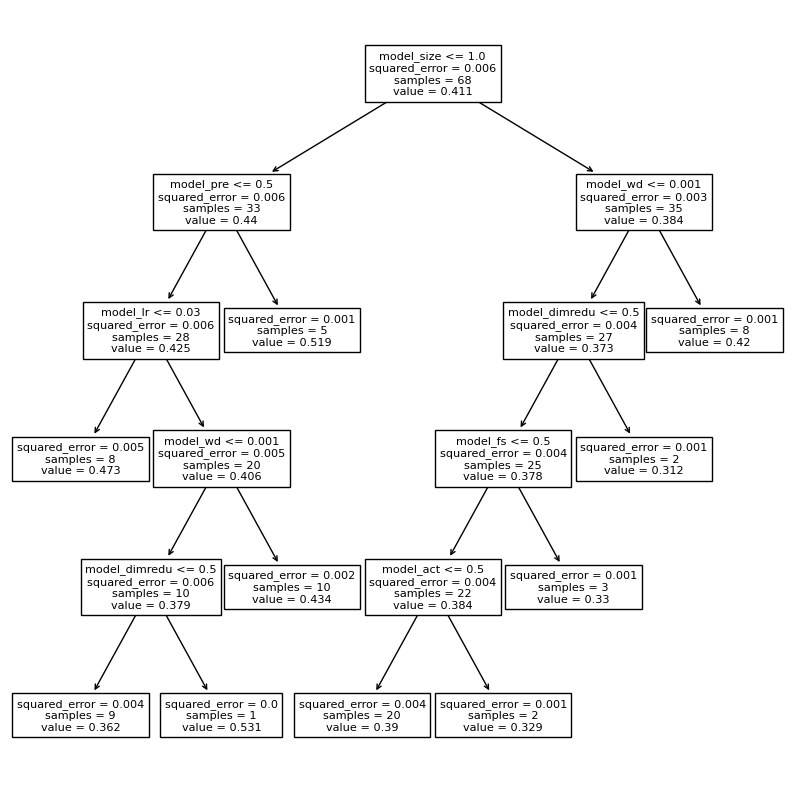

In [21]:
fig, ax = pyplot.subplots(figsize=(10, 10))
plot_tree(dt, feature_names=x_factors, ax=ax)

0      TS1
1      TS1
2      TS1
3      TS1
4      TS1
      ... 
490    TS8
491    TS8
492    TS8
493    TS8
494    TS8
Name: dataset, Length: 495, dtype: object